In [1]:
import blocksci

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
import collections
import random

In [4]:
import datetime

In [5]:
import utils

In [6]:
chain = blocksci.Blockchain(utils.blocksci_config())

In [7]:
my_cm = blocksci.cluster.ClusterManager(utils.latest_clustering(), chain)

In [8]:
gt = blocksci.GroundTruth(utils.latest_groundtruth(), chain)

In [9]:
gt.transactions().size

35257428

In [10]:
all_other = blocksci.GroundTruth(utils.remaining_txes(), chain)

In [11]:
all_other.transactions().size

309653054

In [12]:
gt_max_time_till_spent = gt.transactions().map(lambda tx: tx.outputs.spending_input.max(lambda i: i.age)).age

In [13]:
remaining_max_time_till_spent = all_other.transactions().where(lambda tx: tx.outputs.all(lambda o: o.is_spent)).map(lambda tx: tx.outputs.spending_input.max(lambda i: i.age)).age

In [14]:
len(gt_max_time_till_spent)

35257428

In [15]:
len(remaining_max_time_till_spent)

290358068

In [16]:
np.max(gt_max_time_till_spent), np.max(remaining_max_time_till_spent)

(557276, 621492)

In [17]:
max_x = max(np.max(gt_max_time_till_spent), np.max(remaining_max_time_till_spent))

In [18]:
random.seed(42)
gt_sample = random.sample(gt_max_time_till_spent.tolist(), 250000)
remaining_sample = random.sample(remaining_max_time_till_spent.tolist(), 250000)

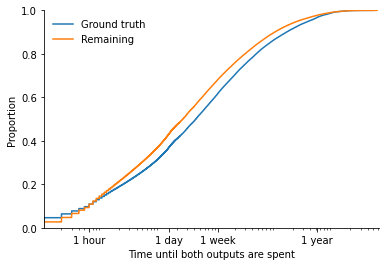

In [19]:
fig, ax = plt.subplots(figsize=(6,4))
sns.ecdfplot(gt_sample, ax=ax)
sns.ecdfplot(remaining_sample, ax=ax)
ax.set_xlim(1, max_x)
ax.set_xscale("log")
ax.set_xticks([6, 144, 1008, 52416])
ax.set_xticklabels(["1 hour", "1 day", "1 week", "1 year"])
ax.legend(["Ground truth", "Remaining"], frameon=False)
ax.set_xlabel("Time until both outputs are spent")
sns.despine()
#plt.tight_layout()
plt.savefig("figures/time-dist-until-spent-log-scale.pdf")

In [20]:
np.mean(gt_max_time_till_spent), np.median(gt_max_time_till_spent)

(6510.273769799657, 419.0)

In [21]:
np.mean(remaining_max_time_till_spent), np.median(remaining_max_time_till_spent)

(5045.121560641463, 256.0)

In [22]:
# check if distributions are different

In [23]:
from scipy.stats import ks_2samp

In [24]:
ks_2samp(gt_max_time_till_spent, remaining_max_time_till_spent)

KstestResult(statistic=0.06446389510107531, pvalue=0.0)

### Create an ECDF with infinite max time for txes with unspent outputs

In [25]:
all_other.transactions().size - len(remaining_max_time_till_spent)

19294986

In [26]:
missing_remaining = int(round(len(remaining_sample) * all_other.transactions().size / len(remaining_max_time_till_spent) - len(remaining_sample), 0))
missing_remaining

16613

In [27]:
remaining_sample_complete = remaining_sample + [9999999 for _ in range(missing_remaining)]

In [28]:
gt_sample_complete = gt_sample + [np.max(gt_max_time_till_spent)]

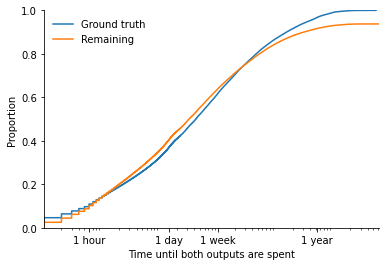

In [29]:
fig, ax = plt.subplots(figsize=(6,4))
sns.ecdfplot(gt_sample_complete, ax=ax)
sns.ecdfplot(remaining_sample_complete, ax=ax)
ax.set_xlim(1, max_x)
ax.set_ylim(0, 1)
ax.set_xscale("log")
ax.set_xticks([6, 144, 1008, 52416])
ax.set_xticklabels(["1 hour", "1 day", "1 week", "1 year"])
ax.legend(["Ground truth", "Remaining"], frameon=False)
ax.set_xlabel("Time until both outputs are spent")
sns.despine()
#plt.tight_layout()
plt.savefig("figures/time-dist-until-spent-log-scale-complete.pdf")

### Extract for full chain

In [30]:
all_max_time_till_spent = chain.blocks.txes.where(lambda tx: tx.outputs.all(lambda o: o.is_spent)).map(lambda tx: tx.outputs.spending_input.max(lambda i: i.age)).age

In [31]:
chain.blocks.txes.size, chain.blocks.txes.where(lambda tx: tx.outputs.all(lambda o: o.is_spent)).size

(652618175, 568170243)

In [32]:
random.seed(42)
all_time_sampled = random.sample(all_max_time_till_spent.tolist(), 250000)

In [33]:
missing_alltime = int(round(len(all_time_sampled) * 543966179 / 467611005 - len(all_time_sampled), 0))
missing_alltime

40822

In [34]:
alltime_sample_complete = all_time_sampled + [9999999 for _ in range(missing_alltime)]

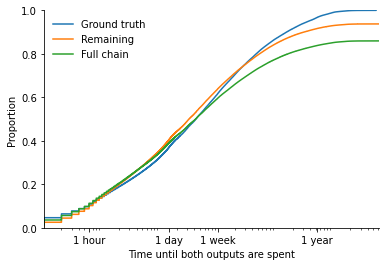

In [35]:
fig, ax = plt.subplots(figsize=(6,4))
#ax.set_clip_on(False)
sns.ecdfplot(gt_sample_complete, ax=ax)
sns.ecdfplot(remaining_sample_complete, ax=ax)
sns.ecdfplot(alltime_sample_complete, ax=ax)
ax.set_xlim(1, max_x)
ax.set_ylim(0, 1)
ax.set_xscale("log")
ax.set_xticks([6, 144, 1008, 52416])
ax.set_xticklabels(["1 hour", "1 day", "1 week", "1 year"])
ax.legend(["Ground truth", "Remaining", "Full chain"], frameon=False)
ax.set_xlabel("Time until both outputs are spent")
sns.despine()
#plt.tight_layout()
plt.savefig("figures/time-dist-until-spent-log-scale-complete-fullchain.pdf")